In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, 
                             fbeta_score,
                             roc_auc_score, 
                             precision_score, 
                             precision_recall_curve, 
                             confusion_matrix,
                             make_scorer
                            )

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
     
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [3]:
def get_metrics(y_test, preds):
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    
    return roc_auc_score(y_test, preds), precision[ix], recall[ix], fscore[ix], thresholds[ix]

__1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)__

In [4]:
df = pd.read_csv("churn_data.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [7]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

- Бустинг

In [8]:
# pipeline_gb = Pipeline([
#     ('features',feats),
#     ('clf', GradientBoostingClassifier(random_state = 42)),
# ])

In [9]:
# params_est = {
#     'clf__n_estimators': [200, 250, 300],
#     'clf__learning_rate': np.linspace(0.09, 0.2, 4),
#     'clf__subsample': [0.6, 0.7, 0.8],
#     'clf__min_samples_leaf': [75, 150, 175],
#     'clf__max_features': ['sqrt', 6],
# }

In [10]:
# grid = GridSearchCV(pipeline_gb,
#                     param_grid=params_est,
#                     cv=6,
#                     refit=False,  
#                     n_jobs=-1)  

# search = grid.fit(X_train, y_train)
# search.best_params_

{'clf__learning_rate': 0.12666666666666668,
 'clf__max_features': 6,
 'clf__min_samples_leaf': 75,
 'clf__n_estimators': 200,
 'clf__subsample': 0.6}

In [11]:
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.127,
                                              max_features=6,
                                              min_samples_leaf=75, 
                                              n_estimators=200,
                                              subsample=0.6,
                                              random_state=42)),
])
pipeline_gb.fit(X_train, y_train)
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]

- логистическая регрессия

In [12]:
# pipeline_lr = Pipeline([
#     ('features',feats),
#     ('clf', LogisticRegression(random_state = 42)),
# ])

In [13]:
# params_est = {'clf__C': np.linspace(0.01, 2, 10)}

# grid = GridSearchCV(pipeline_lr,
#                     param_grid=params_est,
#                     cv=6,
#                     refit=False,  
#                     n_jobs=-1)  

# search = grid.fit(X_train, y_train)
# search.best_params_

{'clf__C': 0.23111111111111113}

In [14]:
pipeline_lr = Pipeline([
    ('features',feats),
    ('clf', LogisticRegression(C=0.231, random_state = 42)),
])
pipeline_lr.fit(X_train, y_train)
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]

__2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)__

In [15]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Так как есть дисбаланс классов, но не чрезмерный, показательной будет оценка ROC-AUC. Но для оценки экономической эффективности может быть удобнее использовать fbeta_score - так как можно более гибко настроить приоритет точности или полноты классификации.

In [16]:
metrics = pd.DataFrame({
    'roc_auc': [],
    'precision': [],
    'recall': [],
    'f_score': [],
    'threshold': []
})

In [17]:
metrics.loc['gb'] = get_metrics(y_test, preds_gb)
metrics.loc['lr'] = get_metrics(y_test, preds_lr)

metrics

,roc_auc,precision,recall,f_score,threshold
gb,0.869549,0.64959,0.622790,0.635908,0.375636
lr,0.772308,0.46400,0.569745,0.511464,0.289131


Лучшая модель по всем метрикам - GradientBoostingClassifier.

__3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.__

In [18]:
cnf_matrix = confusion_matrix(y_test, preds_gb > metrics.loc['gb', 'threshold'])
cnf_matrix

array([[1820,  171],
       [ 193,  316]], dtype=int64)

In [19]:
ret_price = 1
ret_income = 2

total_ret_income = cnf_matrix[1, 1] * ret_income
retention_cost = sum(cnf_matrix[:, 1]) * ret_price
print(f'Доход от удержания: {total_ret_income},\n'
      f'Затраты на удержание: {retention_cost},\n'
      f'Прибыль: {total_ret_income - retention_cost}')

Доход от удержания: 632,
Затраты на удержание: 487,
Прибыль: 145


__4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3__

In [20]:
def economic_efficiency(y_true, y_pred, ret_price=1, ret_income=2):
    profit_th = []
    trh_level = np.linspace(0, 1, 50)

    for trh in trh_level:
        cnf_matrix = confusion_matrix(y_true, y_pred > trh)
        profit_th.append(cnf_matrix[1, 1] * ret_income - sum(cnf_matrix[:, 1]) * ret_price)

    plt.plot(trh_level, profit_th)
    plt.ylabel('руб')
    plt.xlabel('threshold')
    plt.title('profit')
    plt.grid('on');
    
    return trh_level[profit_th.index(max(profit_th))]

0.5918367346938775

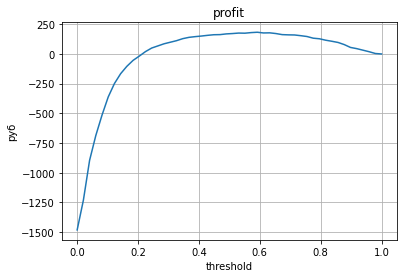

In [21]:
new_trh = economic_efficiency(y_test, preds_gb)
new_trh

In [22]:
cnf_matrix = confusion_matrix(y_test, preds_gb > new_trh)
cnf_matrix

array([[1934,   57],
       [ 269,  240]], dtype=int64)

Т.е. экономически наиболее выгодно до определённого предела уменьшать FP (precision важнее recoll).

In [23]:
precision = cnf_matrix[1, 1] / sum(cnf_matrix[:, 1])
recall = cnf_matrix[1, 1] / sum(cnf_matrix[1])
beta = 0.3
fscore_b = (1 + beta) * precision * recall / ((beta**2 * precision) + recall)
fscore_b

0.9101251422070535

Пусть, к примеру $\beta = 0.3$

Подберём в GridSearchCV параметры с оценкой по метрике fbeta_score

In [24]:
pipeline = Pipeline([
    ('features',feats),
    ('clf', GradientBoostingClassifier(random_state = 42)),
])

In [25]:
f_scorer = make_scorer(fbeta_score, beta=0.3)

params_est = {
    'clf__n_estimators': [200, 250, 300],
    'clf__learning_rate': np.linspace(0.09, 0.2, 4),
    'clf__subsample': [0.6, 0.7, 0.8],
    'clf__min_samples_leaf': [75, 150, 175],
    'clf__max_features': ['sqrt', 6]
}

grid = GridSearchCV(pipeline,
                    param_grid=params_est,
                    cv=6,
                    refit=False,  
                    n_jobs=-1,
                    scoring=f_scorer)

In [26]:
search = grid.fit(X_train, y_train)
search.best_params_

{'clf__learning_rate': 0.09,
 'clf__max_features': 6,
 'clf__min_samples_leaf': 75,
 'clf__n_estimators': 250,
 'clf__subsample': 0.6}

In [27]:
params_gb = {'clf__learning_rate': 0.09,
             'clf__max_features': 6,
             'clf__min_samples_leaf': 75,
             'clf__n_estimators': 250,
             'clf__subsample': 0.6}

pipeline.set_params(**params_gb)
pipeline.fit(X_train, y_train)
preds_gb = pipeline.predict_proba(X_test)[:, 1]

__5. (опционально) Еще раз провести оценку экономической эффективности__

In [28]:
# неплохой результат
roc_auc_score(y_test, preds_gb)

0.871344429105829

0.5714285714285714

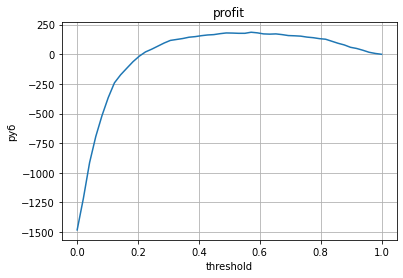

In [32]:
# наиболее выгодный с экономической точки зрения порог
trh = economic_efficiency(y_test, preds_gb)
trh

In [33]:
cnf_matrix = confusion_matrix(y_test, preds_gb > trh)
cnf_matrix

array([[1931,   60],
       [ 263,  246]], dtype=int64)

In [31]:
ret_price = 1
ret_income = 2

# затраты на удержание:
total_ret_income = cnf_matrix[1, 1] * ret_income
retention_cost = sum(cnf_matrix[:, 1]) * ret_price
print(f'Доход от удержания: {total_ret_income},\n'
      f'Затраты на удержание: {retention_cost},\n'
      f'Прибыль: {total_ret_income - retention_cost}')

Доход от удержания: 492,
Затраты на удержание: 306,
Прибыль: 186


Прибыль выросла.